In [9]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from onset_detection.metrics import onset_metric
from onset_detection.read_data import read_data

In [2]:
active_datasets = {1, 2, 3, 4}
X_parts, y_parts, y_start_only_parts, ds_labels = read_data(active_datasets)

D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_FN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_KN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_MN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:151: UserWarning: Skipping non-wav file data\IDMT-SMT-GUITAR_V2\dataset2\audio\desktop.ini
  warn('Skipping non-wav file ' + path_to_wav)
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for FS_Lick11_FN.wav, skipping file.
  warn('No truth foun

In [3]:
X_parts_train, X_parts_test, y_parts_train, y_parts_test, y_start_only_parts_train, y_start_only_parts_test, ds_labels_train, ds_labels_test = train_test_split(
    X_parts, y_parts, y_start_only_parts, ds_labels, test_size=0.2, random_state=42
)

In [4]:
X_train = np.concatenate(X_parts_train)
X_test = np.concatenate(X_parts_test)
y_train = np.concatenate(y_parts_train).ravel()
y_test = np.concatenate(y_parts_test).ravel()

y_start_only_train = np.concatenate(y_start_only_parts_train)
y_start_only_test = np.concatenate(y_start_only_parts_test)

ds_labels_flat_train = []
for y_part, ds_label in zip(y_parts_train, ds_labels_train):
    ds_labels_part = np.empty(len(y_part), dtype=np.int8)
    ds_labels_part.fill(ds_label)
    ds_labels_flat_train.append(ds_labels_part)
ds_labels_flat_train = np.concatenate(ds_labels_flat_train).ravel()

ds_labels_flat_test = []
for y_part, ds_label in zip(y_parts_test, ds_labels_test):
    ds_labels_part = np.empty(len(y_part), dtype=np.int8)
    ds_labels_part.fill(ds_label)
    ds_labels_flat_test.append(ds_labels_part)
ds_labels_flat_test = np.concatenate(ds_labels_flat_test).ravel()

print(X_train.shape)
print(y_train.shape)
print(y_start_only_train.shape)
print(ds_labels_flat_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_start_only_test.shape)
print(ds_labels_flat_test.shape)

(940179, 111)
(940179,)
(940179,)
(940179,)
(231747, 111)
(231747,)
(231747,)
(231747,)


In [5]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
print(X_train.mean())
print(X_train.std())
print(X_test.mean())
print(X_test.std())

5.48495118402e-19
1.0
2.3806596501e-05
1.03017544869


In [6]:
input_dim = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], input_dim, 1)
X_test = X_test.reshape(X_test.shape[0], input_dim, 1)
input_shape = (input_dim, 1)
print(X_train.shape)
print(X_test.shape)
print(input_shape)

(940179, 111, 1)
(231747, 111, 1)
(111, 1)


In [10]:
def create_model(nb_filter=32, filter_length=8, padding='same', input_shape=(111, 1),
                 pool_size=2,
                 n_conv_layers=1, dropout=True):
    model = Sequential()
    model.add(Conv1D(nb_filter, filter_length, padding=padding, input_shape=input_shape))
    model.add(Activation('relu'))
    for i in range(0, n_conv_layers - 1):
        model.add(Convolution1D(nb_filter, filter_length, padding=padding))
        model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    if dropout:
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',)
    
    return model


def fit_predict(clf):
    clf.fit(X_train, y_train)
    y_train_predicted = clf.predict(X_train).ravel()
    y_test_predicted = clf.predict(X_test).ravel()
    
    model = clf.model
    for layer in model.layers:
        print(layer.get_config())
    print('TRAIN')
    print(classification_report(y_train, y_train_predicted))
    print(onset_metric(y_train, y_start_only_train, y_train_predicted, ds_labels_flat_train))
    print('TEST')
    print(classification_report(y_test, y_test_predicted))
    print(onset_metric(y_test, y_start_only_test, y_test_predicted, ds_labels_flat_test))
    print('')

In [11]:
clfs = [
    KerasClassifier(
        build_fn=create_model,
        batch_size=1024, nb_epoch=500,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='loss', patience=4)],
        nb_filter=256, input_shape=input_shape,
    ),
    KerasClassifier(
        build_fn=create_model,
        batch_size=1024, nb_epoch=500,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='loss', patience=4)],
        filter_length=16, input_shape=input_shape,
    ),
    KerasClassifier(
        build_fn=create_model,
        batch_size=1024, nb_epoch=500,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='loss', patience=4)],
        input_shape=input_shape, n_conv_layers=2,
    ),
    KerasClassifier(
        build_fn=create_model,
        batch_size=1024, nb_epoch=500,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='loss', patience=4)],
        input_shape=input_shape, dropout=False,
    ),
]

clfs2 = [
    KerasClassifier(
        build_fn=create_model,
        batch_size=1024, nb_epoch=500,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='loss', patience=4)],
        input_shape=input_shape, nb_filter=64, filter_length=16, n_conv_layers=2,
    ),
]

for clf in clfs2:
    fit_predict(clf)

Train on 940179 samples, validate on 231747 samples
Epoch 1/10
 94208/940179 [==>...........................] - ETA: 77s - loss: 0.2157

KeyboardInterrupt: 

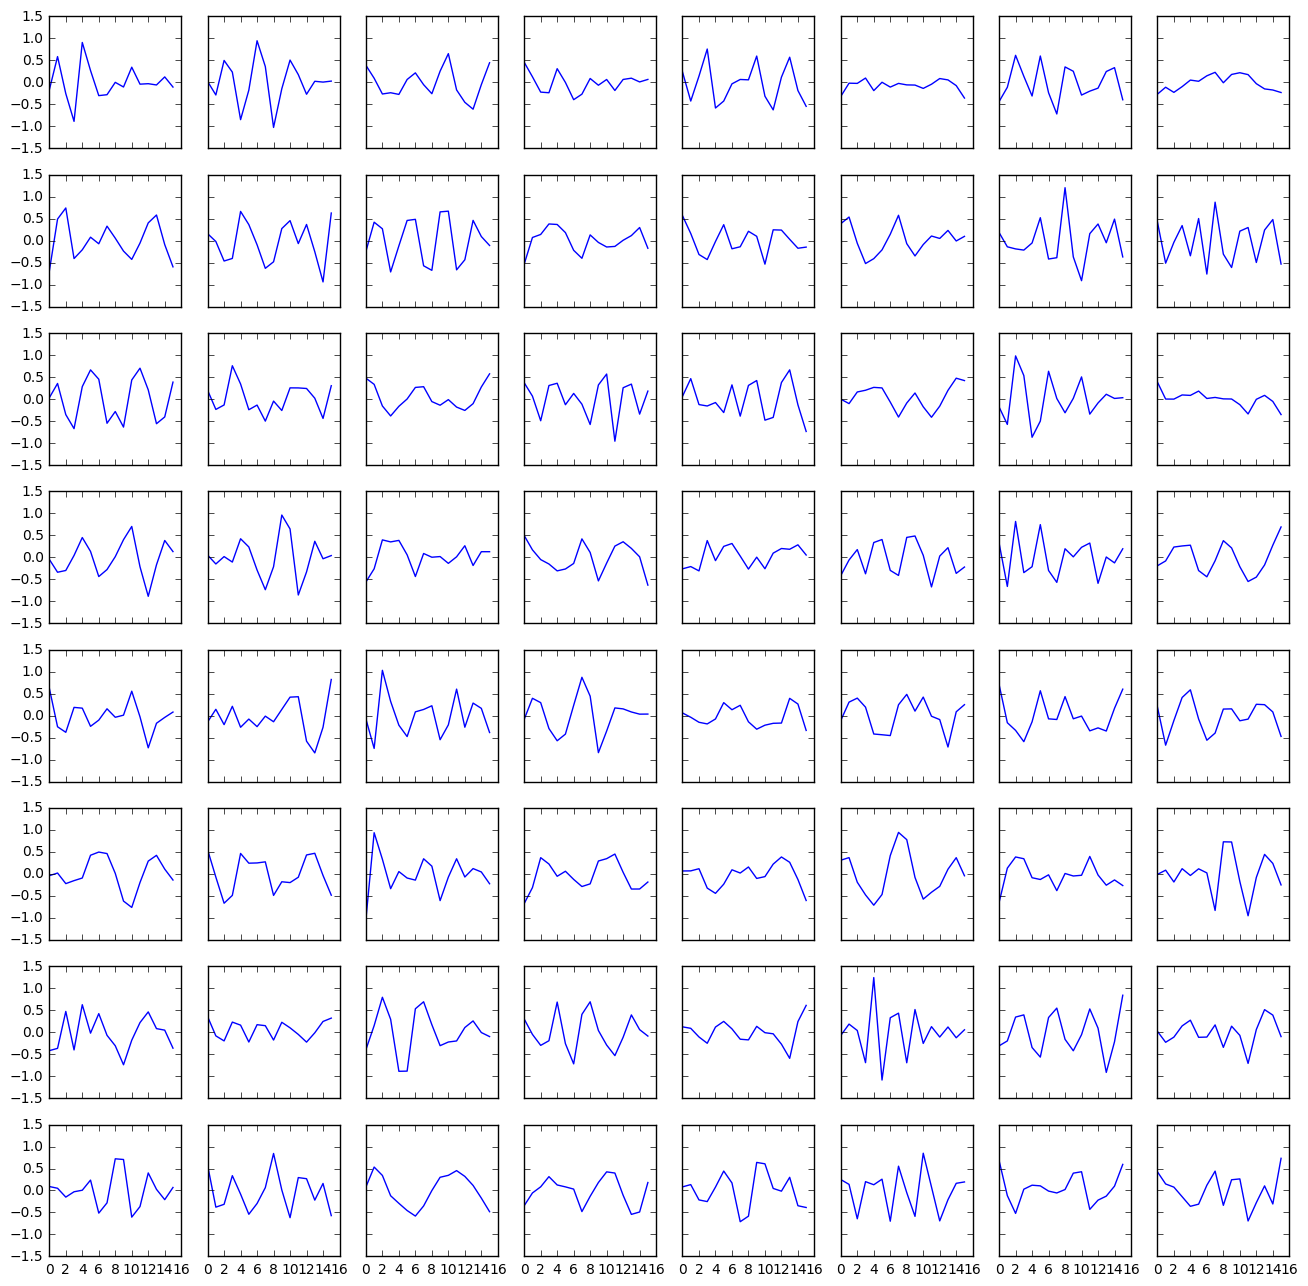

In [10]:
model = clfs2[0].model
for layer in model.layers:
    config = layer.get_config()
    if config['name'].startswith('convolution1d'):
        # squeeze = remove dimensions with shape 1
        filters = np.squeeze(layer.get_weights()[0]).T
        w = 8
        h = config['nb_filter'] // w
        fig, axarr = plt.subplots(h, w, figsize=(w*2, h*2), sharex=True, sharey=True)
        for i in range(h):
            for j in range(w):
                _ = axarr[i, j].plot(filters[i*w + j])
        break